<a href="https://colab.research.google.com/github/deepskies/proj-clusters-sz-sbi/blob/sim_dev/mass_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cluster toolkit: https://cluster-toolkit.readthedocs.io/en/latest/source/massfunction.html
(give up and using colossus instead, see below)

# colossus: https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#lss.mass_function.massFunction

In [ ]:
#bocquet16 200c (universe critical density)
#no below 10^14

In [87]:
! pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import matplotlib.pyplot as plt
import numpy as np
mass_array = np.logspace(14.0, 16.0, num = 200, base = 10)
cosmology.setCosmology('WMAP9')
mfunc = mass_function.massFunction(mass_array, 0.0, mdef = '200c', model = 'bocquet16', q_out = 'dndlnM')

Deleted outdated persistence file, no further action needed.


Text(0.5, 1.0, 'halo mass function plot first attempt')

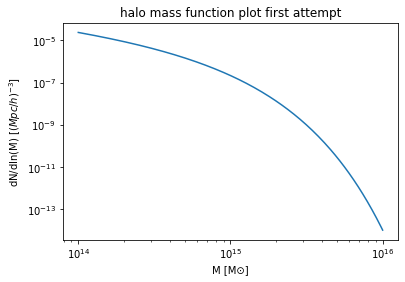

In [89]:
plt.loglog(mass_array, mfunc)
plt.xlabel("M [M⊙]")
plt.ylabel("dN/dln(M) [$(Mpc/ℎ)^{−3}$]")
plt.title("halo mass function plot first attempt")

Text(0.5, 1.0, 'halo mass function plot second attempt')

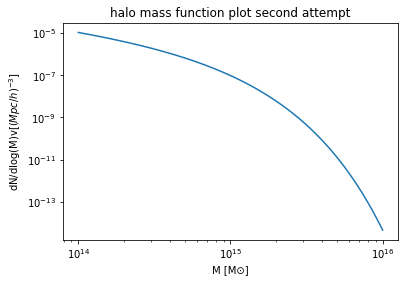

In [90]:
#transition from ln to log10
#ln(number)= log(number)/log(2.71828)
import math
plt.loglog(mass_array, mfunc * math.log10(2.71828))
plt.xlabel("M [M⊙]")
plt.ylabel("dN/dlog(M)v[$(Mpc/ℎ)^{−3}$]")
plt.title("halo mass function plot second attempt")

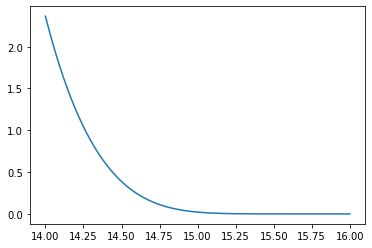

In [91]:
#extract power
from sklearn import preprocessing
mass_array_p = np.log10(mass_array)
mfunc_n = mfunc*(10**5)
mfunc_p_n = preprocessing.normalize([mfunc_n], norm ='l1')
plt.plot(mass_array_p, mfunc_n)

sampling, using emcee and interp1d (still using ln as base)

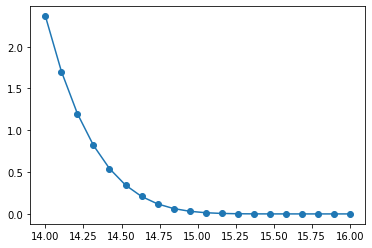

In [92]:
from scipy import interpolate
itp_mfunc = interpolate.interp1d(mass_array_p, mfunc_n)
test_arr = np.linspace(14.0, 16.0, 20)
f_test = itp_mfunc(test_arr)
plt.plot(test_arr, f_test, marker = 'o')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


0.6499258439203269 6.343752753259262e-06
1.0101168273122976 1.9286923566896874e-05


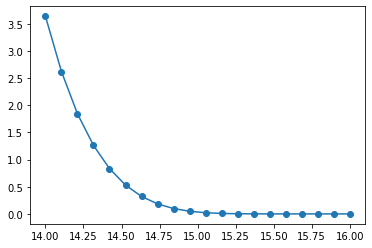

In [93]:
#try to integrate and normalize the function
from scipy import integrate
val, err = integrate.quad(itp_mfunc, 14.0, 16.0)
print(val, err)
plt.plot(test_arr, (f_test/val), marker = 'o')

test_fun = interpolate.interp1d(test_arr, (f_test/val))
nval, nerr = integrate.quad(test_fun, 14.0, 16.0)
print(nval, nerr)


In [94]:
print(-np.inf)

-inf


In [168]:
#the likelihood function, unable to get a perfect pdf, probably be the reason of wrong behavior
def lnpo(mass):
    if (mass < 14) or (mass > 16):
      return -np.inf
    return itp_mfunc(mass)

In [169]:
!pip install emcee
import emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [175]:
#code to demonstrate the final result
def plot_pdf(xr, func=None, args=None, label='ITS method', 
             ylog=True,
             bins = 50, xlims=[], ylims=[], figsize=3):
    """
    by Andrey Kravtsov
    wrapper convenience function for plotting  histogram of a sequence of floats xr
    and comparing it to a theoretical distribution given by func
    
    Parameters:
    -----------
    xr: 1d numpy array of floats, values in the sequence to plot
    func: Python function object handle
    args: list of arguments to the function
    other parameters are used for plotting
    """
    plt.figure(figsize=(figsize,figsize))
    if ylog: plt.yscale('log') # plot y-values on a logarithmic scale
    if ylims: plt.ylim(ylims) # set axis limits 
    if xlims: plt.xlim(xlims)
    # compute histogram values 
    hist, bins, patches = plt.hist(list(xr), density=True, bins=bins, label=label)
    binc = 0.5*(bins[1:] + bins[:-1]) # compute bin centers
    plt.plot(binc, func(binc), lw=5, c='orangered', label='target pdf')
    plt.ylabel(r'$p(x)$') # label axis 
    plt.xlabel(r'$x$')
    plt.legend(loc='best', frameon=False, fontsize=3*figsize)
    plt.show()

In [161]:
#create random walkers
import random
randomlist = []
for i in range(20):
  n = random.uniform(14,16)
  randomlist.append(n)
print(randomlist)
random_arr = np.array(randomlist)

[15.59103640434291, 14.49718057134586, 14.466238074638479, 14.891271989116408, 14.27812208346382, 15.345954848756808, 15.522225074362415, 15.240242776943216, 15.205996958023002, 15.294795318425464, 14.453960827951796, 14.033061408917959, 14.402323950701193, 14.581325987967805, 15.763333291746594, 14.708640935558384, 14.747956783318276, 15.07638463657335, 15.790896695095356, 15.99451808349911]


In [177]:
#run MCMC
ndim, nwalkers = 1, 20

p0 = random_arr.reshape((nwalkers, ndim))
print(p0)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpo)
sampler.run_mcmc(p0, 50000)
chain = sampler.chain

[[15.5910364 ]
 [14.49718057]
 [14.46623807]
 [14.89127199]
 [14.27812208]
 [15.34595485]
 [15.52222507]
 [15.24024278]
 [15.20599696]
 [15.29479532]
 [14.45396083]
 [14.03306141]
 [14.40232395]
 [14.58132599]
 [15.76333329]
 [14.70864094]
 [14.74795678]
 [15.07638464]
 [15.7908967 ]
 [15.99451808]]


In [171]:
flattened = chain.flatten()
print(flattened[:20])


[15.36635324 14.88496885 15.34658726 15.2613303  15.26360676 15.19738763
 15.24629236 15.83516375 15.86111488 15.86111488 15.21034357 15.10561211
 14.79223711 14.51653344 14.60929913 14.59457885 14.50141807 14.89169346
 14.91572556 14.89589867]


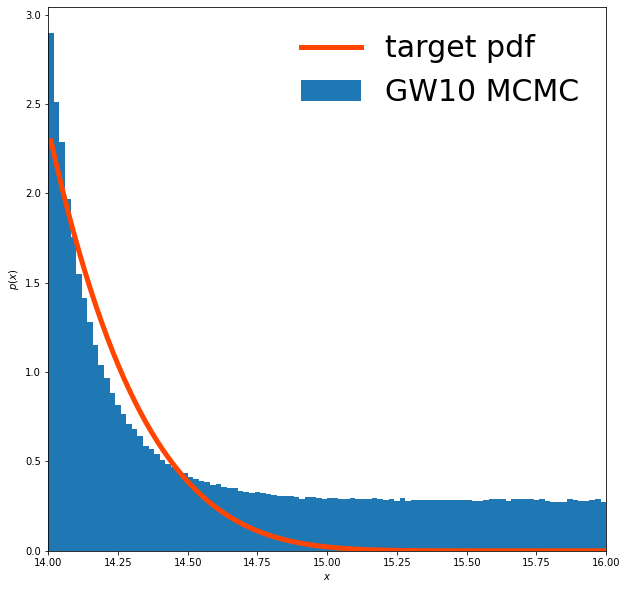

In [178]:
plot_pdf(chain.flatten(), func=itp_mfunc, xlims=[14,16], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)